In [155]:
# Inputs
expected_load = [600, 1500]
expected_latency = [25, 35]
expected_availability = [0.90, 1]
degraded_load = [1500, 3000]

# Problem Definitions
case_study_3_problem = {
    'num_vars': 4,
    'names': ['xLoad', 'zLatency', 'zAvailability', 'newLoad'],
    'bounds': [ expected_load, expected_latency, expected_availability, degraded_load],
    'simulation':{
        'scenario':'load2',
        'models':["A", "B", "C", "O"],
        #'models':["O"],
        'independent':'loadFromX',
        'dependent':[
            'loadFromX', 
            'loadFromY', 
            'meanLatencyFromY',
            "meanAvailabilityFromY",
            "throughput",
            "queueSize"
        ]
    }
}


In [156]:
from SALib.sample import saltelli
import numpy as np
from os import path
import json

# Model Inputs
problem = case_study_3_problem

# Suggesting N = 1000
param_values = saltelli.sample(problem, 512, calc_second_order=False)

casestudy_path = path.join("..", "out", "case-studies")
simulation_file_path = path.join(casestudy_path, "simulation.json")
param_file_path = path.join(casestudy_path, "param_values.txt")

print("saving")
print("\t", simulation_file_path)
print("\t", param_file_path)

np.savetxt(param_file_path, param_values, fmt='%1.4f')
with open(simulation_file_path, 'w', encoding="utf-8") as f:
  json.dump(problem["simulation"], f, ensure_ascii=False, indent=4)

saving
	 ..\out\case-studies\simulation.json
	 ..\out\case-studies\param_values.txt


## Questions To Ask
- Do we want to have this model accept some combination of degradations at the same time or just one?
    > Limit it to just one degradation at a time
- Some scenarios have different architecture? Z has unlimited capacity in most scenarios.
    > I think we need 1 "model" per architecture. Also means, we may need to consider different input distributions per scenario, since they would each be a situation (i.e. we care about latency in this one, so our latency distribution is wider, etc)
- `TICK_DILATION` and output values? How does this affect our sensitivity if we report latency as actual latency scaled by the dilation value?
    > I think we need to care about magnitude here, since the Y axis for sensitivity is this magnitude value.
- We need to remove any random sampling from our models. They need to be deterministic
    > Might be able to get away without determinisim in this case (otherwise, why do they run the models several times with same input)
- We might need to cast inputs to integers (at least some of them)
- We might need to not to do that nan to 0 thing at the end. This migtht mess up some M/S outputs

## Run
```
npx ts-node src/sensitivity/index.ts
```
or with cluster:
```
npx ts-node src/sensitivity/cluster_start.ts
```

In [157]:
def mean_n(datay, start, end):
    if len(datay) < start:
        return np.nan
    if(len(datay) < end):
        return np.nan

    return np.mean(datay[start:end])

metrics = ["T10"]

def get_dependent_name_from_output_index(dependents, output_index):
    index = output_index // len(metrics)
    return dependents[index]

def get_output_name(index):
    """
    Gets the corresponding metric name based on the index of the output
    """
    return metrics[index % len(metrics)]

def get_dependent_output(a, b):
    """
    a: independent series
    b: dependent series
    """
    t10 = mean_n(b, 10, 20)# slice of 20 - 30, corresponding to seconds 10 - 15.
    if np.isnan(t10):
        print("t10 nan")
    return [t10]


def get_output(series, independent, dependents, index):
    independent_series = series[independent]

    result = []
    for d in dependents:
        dependent_series = series[d]
        result += get_dependent_output(independent_series, dependent_series)
    
    return result

In [151]:
# Which simulation results to use, hardcoded because of the disconnect needing to run NodeJS in the previous simulation step
time_series_path = path.join("..", "out", "case-studies", "results-load2-1631239270290")

with open(path.join(time_series_path, "simulation.json")) as json_file:
    output_simulation_data = json.load(json_file)

independent = output_simulation_data["independent"]
dependents = output_simulation_data["dependent"]

In [152]:
import glob
import pandas as pd
import re


for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output = path.join(time_series_path, model)
    time_series_file_name_pattern = path.join(time_series_model_output, "sim", "*.csv")
    all_time_series_csv_files = glob.glob(time_series_file_name_pattern)
    print("\tFound", len(all_time_series_csv_files), "files")

    # sort by the id so each row still matches the id of the time series
    #print(all_time_series_csv_files)
    #print([re.findall("(\d+)\-SteadyLatency\.csv",x) for x in all_time_series_csv_files])
    sorted_time_series_files = sorted(
        all_time_series_csv_files, 
        key=lambda x:float(re.findall("(\d+)\-out\.csv",x)[0])
        )

    #print(sorted_time_series_files)
    #print([re.findall("sim\\\\\w-(\d+)\-.*\.csv",x)[0] for x in all_time_series_csv_files])

    time_series = [pd.read_csv(f) for f in sorted_time_series_files]
    outputs = [get_output(s, independent, dependents, index) for index, s in enumerate(time_series)]

    all_output_file_name = path.join(time_series_model_output, "output_all_values.txt")
    np.savetxt(all_output_file_name, outputs, fmt='%1.8f')



Model: A
	Found 384 files
Model: B
	Found 384 files
Model: C
	Found 384 files
Model: O
	Found 384 files


In [153]:
from SALib.analyze import sobol
import matplotlib.pyplot as plot
from SALib.plotting.bar import plot as barplot


def alert_nan_to_num(o):
    f = np.isfinite(o).all()
    if not f:
        print("uh oh")
    return np.nan_to_num(o)

# to print Numpy Arrays
def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))

print("Assuming independent", independent, "and dependents", dependents)

for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output_path = path.join(time_series_path, model)
    all_output_file_name = path.join(time_series_model_output_path, "output_all_values.txt")

    # tranpose to get {number of output} columns of {number of simulations} rows
    outputs = np.transpose(np.loadtxt(all_output_file_name, float))

    converted = [alert_nan_to_num(o) for o in outputs]
    analysis = [sobol.analyze(problem, o, calc_second_order=False) for o in converted]

    # save in JSON the FULL FILE including invalid NaN values for historical reasoning
    analysis_output_file_name = path.join(time_series_model_output_path, "analysis.json")
    with open(analysis_output_file_name, 'w', encoding="utf-8") as f:
        json.dump(analysis, f, ensure_ascii=False, indent=4, default=default)

    # save only the Total Sensitivity in a csv
    total_sensitivities = dict()
    for d in dependents:
        total_sensitivities[d] = dict()

    for index, a in enumerate(analysis):
        dependent_name = get_dependent_name_from_output_index(dependents, index)
        output_name = get_output_name(index)
        total_sensitivities[dependent_name][output_name] = { "st":a["ST"], "conf":a["ST_conf"] }

    sensitivity_output_file_name = path.join(time_series_model_output_path, "sensitivity.json")
    with open(sensitivity_output_file_name, 'w', encoding="utf-8") as f:
        json.dump(total_sensitivities, f, ensure_ascii=False, indent=4, default=default)
    
    reduced = dict()
    for prop in total_sensitivities:
        reduced[prop] = dict()
        for proxy in total_sensitivities[prop]:
            s = total_sensitivities[prop][proxy]
            reduced[prop][proxy] = {
                "st": s["st"][-1],
                "conf":s["conf"][-1]
            }
    sensitivity_reduced_output_file_name = path.join(time_series_model_output_path, "sensitivity_simple.json")
    with open(sensitivity_reduced_output_file_name, 'w', encoding="utf-8") as f:
        json.dump(reduced, f, ensure_ascii=False, indent=4, default=default)
    
    # print some quick graphs
    for index, a in enumerate(analysis):
        dependent_name = get_dependent_name_from_output_index(dependents, index)
        output_name = get_output_name(index)

        # Manually draw box plots
        df = a.to_df()
        fig, axes = plot.subplots(1, len(df))
        fig.set_tight_layout(True)

        fig.suptitle(f"Sensitivity of {output_name}({index})")
        for idx, f in enumerate(df):
            axes[idx] = barplot(f, ax=axes[idx])

        img_path = path.join(time_series_model_output_path, f"sen-{index}-{dependent_name}-{output_name}.png")
        plot.savefig(img_path, facecolor='white', transparent=False)
        plot.close(fig)
    


Assuming independent loadFromX and dependents ['loadFromX', 'loadFromY', 'meanLatencyFromY', 'meanAvailabilityFromY', 'throughput', 'queueSize']
Model: A
T10
T10
T10
T10
T10
T10
Model: B
T10
T10
T10
T10
T10
T10
Model: C
T10
T10
T10
T10
T10
T10
Model: O
T10
T10
T10
T10
T10
T10


# Scatterplot Matrix

In [154]:
import pandas as pd
import matplotlib.pyplot as plot
from pandas.plotting import scatter_matrix

for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output_path = path.join(time_series_path, model)
    all_output_file_name = path.join(time_series_model_output_path, "output_all_values.txt")


    # tranpose to get {number of output} columns of {number of simulations} rows
    outputs = np.loadtxt(all_output_file_name, float)

    print("\t", np.shape(outputs))

    num_columns = np.shape(outputs)[1]
    num_outputs = len(metrics)
    #print(num_columns, num_outputs)
    for x in range(0, num_columns, num_outputs):
        df = pd.DataFrame(outputs[:, x:x+num_outputs], columns=metrics)
        scatter = scatter_matrix(df, alpha = 0.2, figsize = (5, 5), diagonal = 'hist')

        d = get_dependent_name_from_output_index(dependents, x)
        scatter_file = path.join(time_series_model_output_path, f"scatter_{d}.png")
        plot.savefig(scatter_file, facecolor='white', transparent=False)
        plot.close("all")


    df = pd.DataFrame(outputs)
    df.columns = [get_dependent_name_from_output_index(dependents, x) for x in range(0, num_columns, num_outputs)]
    scatter = scatter_matrix(df, alpha = 0.2, figsize = (30, 30), diagonal = 'hist')
    scatter_file = path.join(time_series_model_output_path, "scatter.png")
    plot.savefig(scatter_file, facecolor='white', transparent=False)
    plot.close("all")
    #print("\tsaved image to ", scatter_file)
    #break

Model: A
	 (384, 6)
Model: B
	 (384, 6)
Model: C
	 (384, 6)
Model: O
	 (384, 6)


# Variance

In [16]:
import pandas as pd
for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output_path = path.join(time_series_path, model)
    all_output_file_name = path.join(time_series_model_output_path, "output_all_values.txt")
    outputs = np.loadtxt(all_output_file_name, float)

    num_columns = np.shape(outputs)[1]
    for x in range(0, num_columns):
        df = pd.DataFrame(outputs[:,x])
        #print(df)
        #print(df.shape)
        d = get_dependent_name_from_output_index(dependents, x)
        print("\t", d, df.var()[0])

    #print(outputs)

Model: G
	 meanLatencyFromY 0.0
	 meanAvailabilityFromY 0.0
	 meanResponseGFastLatency 2.4467095907935268e-05
	 meanResponseGMediumLatency 1.1445645928011126e-05
	 meanResponseGSlowLatency 2.0590155213976543e-05
	 meanResponseGFastAvailability 0.0
	 meanResponseGMediumAvailability 0.0
	 meanResponseGSlowAvailability 0.0


# Case Study 3

In [ ]:
for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output_path = path.join(time_series_path, model)
    all_output_file_name = path.join(time_series_model_output_path, "output_all_values.txt")


# Normal Scenario
x_norm =      [1.00, 0.92, 0.12, 0.01]
xconf_norm =  [0.18, 0.25, 0.06, 0.01]
y_norm =      [1.00, 0.96, 0.03, 1.00]
yconf_norm =  [0.18, 0.25, 0.01, 0.16]
x_norm_label = [1.03, 0.95, 0.12, 0.04]
y_norm_label = [1.03, 0.99, 0.06, 1.03]

# Degraded
x_deg =       [0.84, 0.00, 0.12, 0.01]
xconf_deg =   [0.30, 0.00, 0.08, 0.01]
y_deg =       [0.94, 0.01, 0.03, 0.88]
yconf_deg =   [0.27, 0.01, 0.01, 0.20]
x_deg_label = [0.87, 0.00, 0.15, 0.04]
y_deg_label = [0.97, 0.04, 0.06, 0.91]

x = np.append(x_norm, x_deg)
y = np.append(y_norm, y_deg)
xconf = np.append(xconf_norm, xconf_deg)
yconf = np.append(yconf_norm, yconf_deg)


fig, ax = plot.subplots()
ax.scatter(x, y)
ax.errorbar(x, y, xerr=xconf, yerr=yconf, fmt="o")
for i, txt in enumerate(models):
  ax.annotate(txt, (x_norm_label[i], y_norm_label[i]))
  ax.annotate(txt + "'", (x_deg_label[i], y_deg_label[i]))
ax.set_xlabel("Coupling of Y Latency to Z Latency")
ax.set_ylabel('Coupling of Y Availability to Z Latency')
plot.show()

# Case Study 1

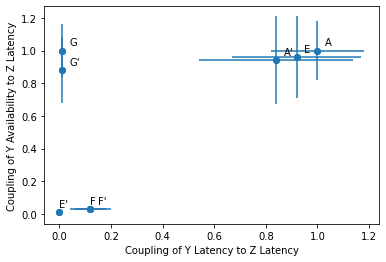

In [32]:
models = latency2_problem["simulation"]["models"]

#x = lat
#y = avail

# Normal Scenario
x_norm =      [1.00, 0.92, 0.12, 0.01]
xconf_norm =  [0.18, 0.25, 0.06, 0.01]
y_norm =      [1.00, 0.96, 0.03, 1.00]
yconf_norm =  [0.18, 0.25, 0.01, 0.16]
x_norm_label = [1.03, 0.95, 0.12, 0.04]
y_norm_label = [1.03, 0.99, 0.06, 1.03]

# Degraded
x_deg =       [0.84, 0.00, 0.12, 0.01]
xconf_deg =   [0.30, 0.00, 0.08, 0.01]
y_deg =       [0.94, 0.01, 0.03, 0.88]
yconf_deg =   [0.27, 0.01, 0.01, 0.20]
x_deg_label = [0.87, 0.00, 0.15, 0.04]
y_deg_label = [0.97, 0.04, 0.06, 0.91]

x = np.append(x_norm, x_deg)
y = np.append(y_norm, y_deg)
xconf = np.append(xconf_norm, xconf_deg)
yconf = np.append(yconf_norm, yconf_deg)


fig, ax = plot.subplots()
ax.scatter(x, y)
ax.errorbar(x, y, xerr=xconf, yerr=yconf, fmt="o")
for i, txt in enumerate(models):
  ax.annotate(txt, (x_norm_label[i], y_norm_label[i]))
  ax.annotate(txt + "'", (x_deg_label[i], y_deg_label[i]))
ax.set_xlabel("Coupling of Y Latency to Z Latency")
ax.set_ylabel('Coupling of Y Availability to Z Latency')
plot.show()


# Case Study 2 v2
Availability Scenario in Scatter Plot

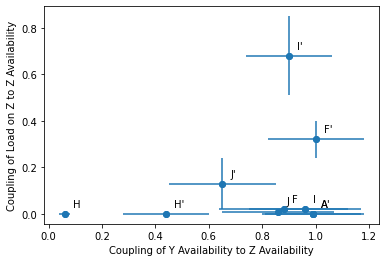

In [35]:
models = availability2_problem["simulation"]["models"]
# A, F, H, I, J
#x = avail
#y = load

"""
# Normal
x_norm      = [1.00, 0.32, 1.00, 0.24, 0.48]
xconf_norm  = [0.07, 0.07, 0.10, 0.15, 0.14]
y_norm      = [0.00, 0.00, 0.39, 0.65, 0.43]
yconf_norm  = [0.00, 0.00, 0.06, 0.09, 0.13]
x_norm_label = [1.01, 0.35, 1.03, 0.27, 0.51]
y_norm_label = [0.03, 0.03, 0.42, 0.68, 0.47]

# Degraded
x_deg     = [1.00, 0.15, 1.00, 0.27, 0.30]
xconf_deg = [0.09, 0.04, 0.09, 0.12, 0.07]
y_deg     = [0.00, 0.00, 0.13, 0.40, 0.21]
yconf_deg = [0.00, 0.00, 0.02, 0.05, 0.07]
x_deg_label = [1.03, 0.18, 1.03, 0.30, 0.33]
y_deg_label = [0.03, 0.03, 0.16, 0.43, 0.24]
"""

# Normal
x_norm      = [0.99, 0.06, 0.88, 0.96, 0.86]
xconf_norm  = [0.19, 0.02, 0.24, 0.21, 0.21]
y_norm      = [0.00, 0.00, 0.02, 0.02, 0.01]
yconf_norm  = [0.00, 0.00, 0.00, 0.01, 0.00]
x_norm_label = [1.02, 0.09, 0.91, 0.99, 0.89]
y_norm_label = [0.03, 0.03, 0.05, 0.05, 0.04]

# Degraded
x_deg     = [0.99, 0.44, 1.00, 0.90, 0.65]
xconf_deg = [0.18, 0.16, 0.18, 0.16, 0.20]
y_deg     = [0.00, 0.00, 0.32, 0.68, 0.13]
yconf_deg = [0.00, 0.00, 0.08, 0.17, 0.11]
x_deg_label = [1.02, 0.47, 1.03, 0.93, 0.68]
y_deg_label = [0.03, 0.03, 0.35, 0.71, 0.16]

x = np.append(x_norm, x_deg)
y = np.append(y_norm, y_deg)
xconf = np.append(xconf_norm, xconf_deg)
yconf = np.append(yconf_norm, yconf_deg)

fig, ax = plot.subplots()
ax.scatter(x, y)
ax.errorbar(x, y, xerr=xconf, yerr=yconf, fmt="o")
for i, txt in enumerate(models):
  ax.annotate(txt, (x_norm_label[i], y_norm_label[i]))
  ax.annotate(txt + "'", (x_deg_label[i], y_deg_label[i]))
ax.set_xlabel("Coupling of Y Availability to Z Availability")
ax.set_ylabel('Coupling of Load on Z to Z Availability')
plot.show()

# Case Study 2.5

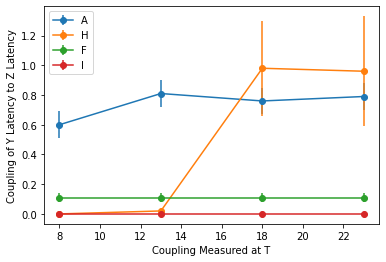

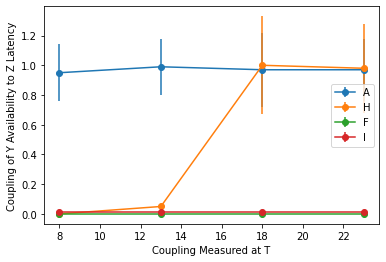

In [5]:
models = availability2_problem["simulation"]["models"]

# Degraded Scenario
x_time = [8, 13, 18, 23]

# coupling at 10.
# x_deg = [0.75, 0.00, 0.11, 0.00]
# xconf_deg = [0.10, 0.00, 0.03, 0.00]
y_lat_coupling = [
  [0.60, 0.81, 0.76, 0.79],
  [0.00, 0.02, 0.98, 0.96],
  [0.11, 0.11, 0.11, 0.11],
  [0.00, 0.00, 0.00, 0.00]
]
lat_confidences = [
  [0.09, 0.09, 0.09, 0.09],
  [0.00, 0.01, 0.32, 0.37],
  [0.03, 0.03, 0.03, 0.03],
  [0.00, 0.00, 0.00, 0.00]
]
# coupling at 10
# y_deg = [0.97, 0.01, 0.00, 0.01]
# yconf_deg = [0.17, 0.00, 0.00, 0.00]
y_avail_coupling = [
  [0.95, 0.99, 0.97, 0.97],
  [0.00, 0.05, 1.00, 0.98],
  [0.00, 0.00, 0.00, 0.00],
  [0.01, 0.01, 0.01, 0.01]
]
avail_confidences = [
  [0.19, 0.19, 0.25, 0.21],
  [0.00, 0.02, 0.33, 0.30],
  [0.00, 0.00, 0.00, 0.00],
  [0.00, 0.00, 0.00, 0.00]
]



fig, ax = plot.subplots()
for i, y in enumerate(y_lat_coupling):
  ax.errorbar(x_time, y, yerr=lat_confidences[i], fmt='-o')

ax.set_xlabel("Coupling Measured at T")
ax.set_ylabel('Coupling of Y Latency to Z Latency')
ax.legend(models)
plot.show()


fig2, ax2 = plot.subplots()
for i, y in enumerate(y_avail_coupling):
  ax2.errorbar(x_time, y, yerr=avail_confidences[i], fmt='-o')


ax2.set_xlabel("Coupling Measured at T")
ax2.set_ylabel('Coupling of Y Availability to Z Latency')
ax2.legend(models)
plot.show()
